# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# import packages and libraries
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [25]:
# Add any additional import statements you need here
from collections import defaultdict
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


In [3]:
# data location for Mod 1 Assignment
data_location = "C:/Users/marvi/GitHub Projects/text-compare/M1 Results/"

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [4]:
# Data location for new files
new_data_location = "C:/Users/marvi/GitHub Projects/ads-sentiment-analysis/"

# Define the full file paths by combining the base path and file names
positive_words_file = new_data_location + "positive-words.txt"
negative_words_file = new_data_location + "negative-words.txt"
tidy_text_file = new_data_location + "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# read in the lyrics here

# Base folder for the lyrics data
data_location = "C:/Users/marvi/GitHub Projects/text-compare/M1 Results/"
lyrics_folder = data_location + "lyrics/"

# Define the subfolders for Cher and Robyn
artist_folders = {
    'cher': 'cher/', 
    'robyn': 'robyn/' 
}

# Initialize an empty list to store the lyrics data
lyrics_data = []

# Function to read all text files in a folder
def read_lyrics_from_folder(artist, folder_path):
    lyrics_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                lyrics = file.read() 
                song_title = filename.replace('.txt', '')
                lyrics_list.append({
                    'song_title': song_title,
                    'artist': artist,
                    'lyrics': lyrics
                })
    return lyrics_list

# Read Cher's lyrics
cher_lyrics = read_lyrics_from_folder('cher', lyrics_folder + artist_folders['cher'])

# Read Robyn's lyrics
robyn_lyrics = read_lyrics_from_folder('robyn', lyrics_folder + artist_folders['robyn'])

# Combine both artists' lyrics
lyrics_data.extend(cher_lyrics)
lyrics_data.extend(robyn_lyrics)

# Convert the list of dictionaries into a DataFrame
lyrics_df = pd.DataFrame(lyrics_data)

# Display a preview of the combined lyrics data
print(lyrics_df.head())

                      song_title artist  \
0                 cher_88degrees   cher   
1  cher_adifferentkindoflovesong   cher   
2                  cher_afterall   cher   
3                     cher_again   cher   
4                     cher_alfie   cher   

                                              lyrics  
0  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...  
1  "A Different Kind Of Love Song"\n\n\n\nWhat if...  
2  "After All"\n\n\n\nWell, here we are again\nI ...  
3  "Again"\n\n\n\nAgain evening finds me at your ...  
4  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...  


In [6]:
# Read in the twitter data
# Initialize an empty dictionary to store the twitter data
twitter_data_dict = {}

# Load Twitter data for Cher (only keeping the description)
cher_twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                                sep="\t", quoting=3, usecols=['description'])  # Only keep description column

# Store descriptions in the dictionary with artist as the key
twitter_data_dict['cher'] = cher_twitter_data['description'].tolist()

# Load Twitter data for Robyn (only keeping the description)
robyn_twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                                 sep="\t", quoting=3, usecols=['description'])  # Only keep description column

# Store descriptions in the dictionary with artist as the key
twitter_data_dict['robyn'] = robyn_twitter_data['description'].tolist()

# Display only a small part of the twitter data dictionary
for artist, descriptions in twitter_data_dict.items():
    print(f"Artist: {artist}")
    print(descriptions[:5]) 

Artist: cher
[nan, '𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜', '163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡', 'csu', 'Writer @Washinformer @SpelmanCollege alumna #DCnative Award-winning journalist & PR pro @IABC Fellow & Past Chair IG: bcscomm Email: wibsiler@gmail.com']
Artist: robyn
['"I love chill" •Facebook / Instagram / SoundCloud: AngelxoArts• https://t.co/447okKLKzA…', "books, movies, music, nature & TV shows. OG Sweetee since '12 thanks to YouTube recommending 'This Feeling' on my homepage ♥️", '(Am)auteur en herbe 🌱 - juriste en paille 🤡 - Ami des fleurs 🌸🌈 (sans la main verte) - music & books - #morecomingsoon... (si on en voit le bout)', 'This Twitter profile is full of sarcasm and rants with the occasional moan, dont like me dont follow me! KLF Stan Account Aspiring Youth Council rep', 'Flora Youssef - Blogger & Founder Posting review articles about the latest music 🎵 https://t.co/dx4hoIom7T https://t.co/KsplT6mZzs']


In [7]:
# Function to read words from a text file
def read_words_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        words = [line.strip() for line in file if line.strip() and not line.startswith(";")]  # Ignore empty lines and comments
    return words

# Read positive and negative words using the existing file paths
positive_words = read_words_from_file(positive_words_file)
negative_words = read_words_from_file(negative_words_file)

# Assign scores to positive and negative words
word_sentiments = {word: 1 for word in positive_words}
word_sentiments.update({word: -1 for word in negative_words})

# Print a sample of the word sentiment dictionary
print(list(word_sentiments.items())[:10])  # Show first 10 entries

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1), ('accessable', 1), ('accessible', 1), ('acclaim', 1), ('acclaimed', 1), ('acclamation', 1)]


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [8]:
# Define Function to compute sentiment score
def calculate_sentiment(text, sentiment_dict):
    words = text.split()  # Tokenize text into words
    score = sum([sentiment_dict.get(word.lower(), 0) for word in words])  # Sum the scores of words
    return score

In [11]:
# Apply sentiment analysis to the lyrics of all songs
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(lambda x: calculate_sentiment(x, word_sentiments))

# Define path for output file with results
output_file_path = "C:/Users/marvi/GitHub Projects/ads-sentiment-analysis/lyrics_sentiment_scores.csv"

# Save the DataFrame to a CSV file
lyrics_df[['artist', 'song_title', 'sentiment_score']].to_csv(output_file_path, index=False)

print(f"Sentiment scores saved to: {output_file_path}")

Sentiment scores saved to: C:/Users/marvi/GitHub Projects/ads-sentiment-analysis/lyrics_sentiment_scores.csv


In [12]:
# Calculate the average sentiment score for each artist
average_sentiment = lyrics_df.groupby('artist')['sentiment_score'].mean().reset_index()

# Rename the columns for clarity
average_sentiment.columns = ['artist', 'average_sentiment_score']

# Display the result
print(average_sentiment)

  artist  average_sentiment_score
0   cher                 3.161392
1  robyn                 2.019231


In [13]:
# Get the first artist in the DataFrame
first_artist = lyrics_df['artist'].iloc[0]

# Filter the songs for the first artist
artist_songs = lyrics_df[lyrics_df['artist'] == first_artist]

# Sort by sentiment score in descending order to get the highest sentiment
sorted_songs = artist_songs.sort_values(by='sentiment_score', ascending=False)

# Get the top 3 songs with the highest sentiment
top_3_songs = sorted_songs.head(3)

# Get the bottom 3 songs with the lowest sentiment (ascending order)
bottom_3_songs = sorted_songs.tail(3)

# Print the top 3 songs' titles, scores, and lyrics
print("Top 3 songs with the highest sentiment scores:")
for index, row in top_3_songs.iterrows():
    print(f"Song: {row['song_title']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

# Print the bottom 3 songs' titles, scores, and lyrics
print("Bottom 3 songs with the lowest sentiment scores:")
for index, row in bottom_3_songs.iterrows():
    print(f"Song: {row['song_title']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")


Top 3 songs with the highest sentiment scores:
Song: cher_perfection, Sentiment Score: 41
Lyrics:
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had 

In [14]:
# Get the second artist in the DataFrame
second_artist = lyrics_df['artist'].unique()[1]

# Filter the songs for the second artist
artist_songs = lyrics_df[lyrics_df['artist'] == second_artist]

# Sort by sentiment score in descending order to get the highest sentiment
sorted_songs = artist_songs.sort_values(by='sentiment_score', ascending=False)

# Get the top 3 songs with the highest sentiment
top_3_songs = sorted_songs.head(3)

# Get the bottom 3 songs with the lowest sentiment (ascending order)
bottom_3_songs = sorted_songs.tail(3)

# Print the top 3 songs' titles, scores, and lyrics
print(f"Top 3 songs with the highest sentiment scores for {second_artist}:")
for index, row in top_3_songs.iterrows():
    print(f"Song: {row['song_title']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

# Print the bottom 3 songs' titles, scores, and lyrics
print(f"Bottom 3 songs with the lowest sentiment scores for {second_artist}:")
for index, row in bottom_3_songs.iterrows():
    print(f"Song: {row['song_title']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")


Top 3 songs with the highest sentiment scores for robyn:
Song: robyn_loveisfree, Sentiment Score: 91
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Bo

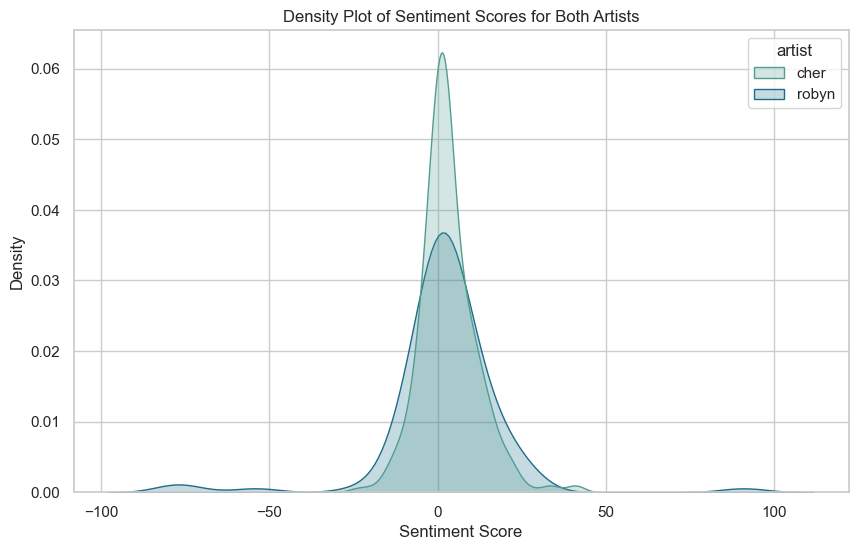

In [16]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=lyrics_df, x="sentiment_score", hue="artist", fill=True, common_norm=False, palette="crest")

# Add labels and title
plt.title('Density Plot of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

# Show the plot
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Based on the output above, Cher has a higher sentiment average.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Cher, the 3 songs with the highest sentiment scores are "perfection", "Love and Understanding", and "My Love". For these songs, it is the theme that is driving such score. Even based of the tittle alone one can make such an assumption. On the recerve, the 3 songs with the lowest sentiment score are "Criminal Intent", "Don't Fucking Tell Me What To Do", and "I Walk On Guilded Splinters". Similarly, I believe it is the theme that is driving such score.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Robyn, the 3 songs with the highest sentiment scores are "Love is Free", "Indestructible", and "U Should Know Better". For these songs, it is the resilient-type theme that is driving such score. Even based of the tittle alone one can make such an assumption. On the recerve, the 3 songs with the lowest sentiment score are "Criminal Intent", and "Don't Fucking Tell Me What To Do". Similarly, I believe it is the violent theme that is driving such score.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [17]:
# Define positive emojis
positive_emojis = ['😊', '😁', '😄', '😍', '❤️', '👍', '🎉', '✨', '😎', '😂']

# Define negative emojis
negative_emojis = ['😢', '😡', '😭', '👎', '😞', '💔', '😠', '😨', '😱', '😔']

In [18]:
# Assign scores to positive and negative emojis
emoji_sentiments = {emoji: 1 for emoji in positive_emojis}
emoji_sentiments.update({emoji: -1 for emoji in negative_emojis})

In [23]:
# Define function to calculate emoji-based sentiment score
def calculate_emoji_sentiment(description, emoji_dict):
    score = 0
    # Check if the description is a valid string
    if isinstance(description, str):
        for char in description:
            if char in emoji_dict:
                score += emoji_dict[char]
    return score

In [24]:
# Initialize a dictionary to store average emoji sentiment scores for each artist
average_emoji_sentiment = {}

# Iterate over the twitter_data_dict and calculate sentiment for each artist
for artist, descriptions in twitter_data_dict.items():
    total_score = 0
    num_descriptions = len(descriptions)
    
    # Calculate the total sentiment score for all descriptions of the current artist
    for description in descriptions:
        total_score += calculate_emoji_sentiment(description, emoji_sentiments)
    
    # Calculate the average sentiment score (total score / number of descriptions)
    if num_descriptions > 0:
        average_sentiment = total_score / num_descriptions
    else:
        average_sentiment = 0  # Avoid division by zero if there are no descriptions
    
    # Store the average sentiment for the artist
    average_emoji_sentiment[artist] = average_sentiment

# Print the average emoji sentiment score for each artist
for artist, avg_sentiment in average_emoji_sentiment.items():
    print(f"Artist: {artist}, Average Emoji Sentiment Score: {avg_sentiment}")

Artist: cher, Average Emoji Sentiment Score: 0.013613687583592984
Artist: robyn, Average Emoji Sentiment Score: 0.009091112028841539


In [26]:
# Function to count positive and negative emojis in descriptions
def count_emojis(descriptions, emoji_set):
    emoji_counter = Counter()
    for description in descriptions:
        if isinstance(description, str):
            for char in description:
                if char in emoji_set:
                    emoji_counter[char] += 1
    return emoji_counter

In [27]:
# Initialize a dictionary to store the most popular positive and negative emoji for each artist
most_popular_emojis = {}

# Iterate over the twitter_data_dict for each artist
for artist, descriptions in twitter_data_dict.items():
    
    # Count positive and negative emojis
    positive_emoji_count = count_emojis(descriptions, positive_emojis)
    negative_emoji_count = count_emojis(descriptions, negative_emojis)
    
    # Identify the most popular positive and negative emoji
    most_popular_positive = positive_emoji_count.most_common(1)[0] if positive_emoji_count else ('None', 0)
    most_popular_negative = negative_emoji_count.most_common(1)[0] if negative_emoji_count else ('None', 0)
    
    # Store the results for the artist
    most_popular_emojis[artist] = {
        'most_popular_positive': most_popular_positive,
        'most_popular_negative': most_popular_negative
    }

# Display the most popular emojis for each artist
for artist, emojis in most_popular_emojis.items():
    print(f"Artist: {artist}")
    print(f"Most popular positive emoji: {emojis['most_popular_positive'][0]} (used {emojis['most_popular_positive'][1]} times)")
    print(f"Most popular negative emoji: {emojis['most_popular_negative'][0]} (used {emojis['most_popular_negative'][1]} times)\n")

Artist: cher
Most popular positive emoji: ✨ (used 29468 times)
Most popular negative emoji: 💔 (used 1611 times)

Artist: robyn
Most popular positive emoji: ✨ (used 2223 times)
Most popular negative emoji: 💔 (used 60 times)



Q: What is the average sentiment of your two artists? 

A: For cher, the average Emoji Sentiment Score = 0.013613687583592984.
For robyn, the average Emoji Sentiment Score: 0.009091112028841539.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Artist: cher
Most popular positive emoji: ✨ (used 29468 times)
Most popular negative emoji: 💔 (used 1611 times)

Artist: robyn
Most popular positive emoji: ✨ (used 2223 times)
Most popular negative emoji: 💔 (used 60 times)
